# 🛠 Install Libraries

In [1]:
!pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl
!pip install -q ../input/segmentation-models-pytorch-021/segmentation_models_pytorch-0.2.1-py3-none-any.whl
# !pip install -q ../input/segmentation-tta-qubvel/ttach-0.0.3-py3-none-any.whl
# !pip install -q ../input/ttachseg/ttach-master
# !pip install ipdb

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


# 📚 Import Libraries 

In [2]:
import re
from collections import Counter
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
# import ttach as tta
from pathlib import Path
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.nn.functional as F

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ⚙️ Configuration 

In [3]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'v4'
    comment       = 'unet-efficientnet_b0-320x384'
    bb_path       = []
    model_name    = 'Unet'
    backbone      = {'rsn269':'tu-resnest269e',
                     'rrs420':'tu-resnetrs420', 
                     'v2l21':'tu-tf_efficientnetv2_l_in21ft1k', 
                     'b7':'efficientnet-b7', 
                     'b5':'efficientnet-b5', 
                     'tb8':'timm-efficientnet-b8', 
                     'rsn5040':'tu-resnest50d_4s2x40d',
                     'ecnfl2':'tu-eca_nfnet_l2',
                     'ecr269':'tu-ecaresnet269d',
                    }
    shared_enc    = True
    train_bs      = 40
    valid_bs      = train_bs*2
    img_size      = [320, 384]
    epochs        = 16
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    folds         = [0]
    num_classes   = 3
    thr           = [0.33, 0.37, 0.4]
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    scaling_factor = 16384.0
    TTA_FLAG      = False
    cropped_analysis = True
    
BASE_PATH  = '/kaggle/input/uw-madison-gi-tract-image-segmentation'
# CKPT_DIR = '/kaggle/input/uwmgi-unet-effnetb0-25d-320x384-ckpt-ds'
CKPT_DIRS = [
    '../input/full-rsn5040-bs80-e25',
#     '../input/full-v2l21-bs48-e25',
#     '../input/full-uppfpn-ecr269-c-bs48-e25',
#     '../input/full-rsn269-scse-bs32-e25-3loss',
    '../input/full-tb8-scse-bs32-e25-3loss',
#     '../input/full-uppfpn-rrs420-lr-e25',
#     '../input/full-uppfpn-rsn269-c-bs32-e25',
#     '../input/full-uppfpn-tb8-lr-e25',
    '../input/uppfpn-b7-c-bs48-e50',
    '../input/uppfpn-tb8-c-bs32-e30',
            ]

import os, shutil
from pprint import pprint
os.makedirs("/root/.cache/torch/hub/checkpoints/", exist_ok=True)
# shutil.copy(f"{CFG.bb_path[0]}", "/root/.cache/torch/hub/checkpoints/")
# shutil.copy("/root/.cache/torch/hub/checkpoints/tf_efficientnetv2_l_21ft1k-60127a9d.pth", "./")

# ❗ Reproducibility

In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 🔨 Utility

In [5]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
#     row['id'] = f'case{case}_day{day}_slice_{slice_}'
    return row

In [6]:
def load_img(path, size=CFG.img_size):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        img = np.pad(img, [pady, padx])
        img = img.reshape((*resize))
    return img, shape0

def load_imgs(img_paths, size=CFG.img_size, scaling_factor = CFG.scaling_factor):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.float32)
    for i, img_path in enumerate(img_paths):
        if i==0:
            img, shape0 = load_img(img_path, size=size)
        else:
            img, _ = load_img(img_path, size=size)
        img = img.astype('float32') # original is uint16
        img /= float(scaling_factor) # scale image to [0, 1]
        imgs[..., i]+=img
    return imgs, shape0

def load_msk(path, size=CFG.img_size):
    msk = np.load(path)
    shape0 = np.array(msk.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        msk = np.pad(msk, [pady, padx, [0,0]])
        msk = msk.reshape((*resize, 3))
    msk = msk.astype('float32')
    msk/=255.0
    return msk

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [7]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Test

In [8]:
sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
if not len(sub_df):
    debug = True
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')[:1000*3]
    sub_df = sub_df.drop(columns=['class','segmentation']).drop_duplicates()
else:
    debug = False
    sub_df = sub_df.drop(columns=['class','predicted']).drop_duplicates()
sub_df = sub_df.progress_apply(get_metadata,axis=1)

100%|██████████| 1000/1000 [00:01<00:00, 652.66it/s]


In [9]:
if debug:
    paths = glob(f'/kaggle/input/uw-madison-gi-tract-image-segmentation/train/**/*png',recursive=True)
    fold_val = '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/'
    paths = sorted(paths)
else:
    paths = glob(f'/kaggle/input/uw-madison-gi-tract-image-segmentation/test/**/*png',recursive=True)
    fold_val = '/kaggle/input/uw-madison-gi-tract-image-segmentation/test/'
    paths = sorted(paths)
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df = path_df.progress_apply(path2info, axis=1)
path_df.head()

100%|██████████| 38496/38496 [01:41<00:00, 379.52it/s]


,image_path,height,width,case,day,slice
0,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,101,20,1
1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,101,20,2
2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,101,20,3
3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,101,20,4
4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,101,20,5


In [10]:
im_path_ls = list(paths)
len(im_path_ls)
im_path_ls = sorted(im_path_ls)

## Intensity DF

In [11]:
def assess_im(path):
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    return img.min(), img.max(), Path(path).parent.parent.stem

im_dims = Parallel(n_jobs=-1, backend='threading')(delayed(assess_im)(path_)\
                                                   for path_ in tqdm(im_path_ls, total=len(im_path_ls)))

100%|██████████| 38496/38496 [02:59<00:00, 214.56it/s]


In [12]:
intensity_tmp_df = pd.DataFrame(columns=['min_value', 'max_value', 'name'])
for item in im_dims:
    intensity_tmp_df.loc[len(intensity_tmp_df)] = item
intensity_tmp_df['min_min'] = -1
intensity_tmp_df['min_max'] = -1
intensity_tmp_df['max_min'] = -1
intensity_tmp_df['max_max'] = -1
for case in intensity_tmp_df.name.unique():
    intensity_tmp_df.loc[intensity_tmp_df.name == case, 'min_min'] = float(intensity_tmp_df[intensity_tmp_df.name == case].min_value.min())
    intensity_tmp_df.loc[intensity_tmp_df.name == case, 'min_max'] = float(intensity_tmp_df[intensity_tmp_df.name == case].min_value.max())
    intensity_tmp_df.loc[intensity_tmp_df.name == case, 'max_min'] = float(intensity_tmp_df[intensity_tmp_df.name == case].max_value.min())
    intensity_tmp_df.loc[intensity_tmp_df.name == case, 'max_max'] = float(intensity_tmp_df[intensity_tmp_df.name == case].max_value.max())
intensity_df = intensity_tmp_df.copy()
intensity_df = intensity_df.drop(columns=['min_value', 'max_value'])
intensity_df = intensity_df.sort_values(by ='max_max')
intensity_df = intensity_df.drop_duplicates()#.reset_index()
intensity_df = intensity_df.reset_index(drop=True)
intensity_df.head()

,name,min_min,min_max,max_min,max_max
0,case15_day0,0,0,135,659
1,case2_day5,0,0,119,697
2,case2_day4,0,0,135,702
3,case15_day20,0,0,143,723
4,case2_day2,0,0,102,760


In [13]:
intensity_df[['case', 'day']] = intensity_df['name'].str.split('_', 1, expand=True)
intensity_df['case'] = intensity_df.case.str.replace('case','').astype(int)
intensity_df['day'] = intensity_df.day.str.replace('day','').astype(int)
intensity_df.head()

,name,min_min,min_max,max_min,max_max,case,day
0,case15_day0,0,0,135,659,15,0
1,case2_day5,0,0,119,697,2,5
2,case2_day4,0,0,135,702,2,4
3,case15_day20,0,0,143,723,15,20
4,case2_day2,0,0,102,760,2,2


## Cropping

In [14]:
name_ls = [x.replace(fold_val,'').split('/')[1] for x in im_path_ls if re.match('case[0-9]+_day[0-9]+',x.replace(fold_val,'').split('/')[1])]
assert len(name_ls) == len(im_path_ls)

In [15]:
test_df = sub_df.merge(path_df, on=['case','day','slice'], how='left')
test_df.head()

,id,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
1,case123_day20_slice_0002,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
2,case123_day20_slice_0003,123,20,3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
3,case123_day20_slice_0004,123,20,4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
4,case123_day20_slice_0005,123,20,5,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266


In [16]:
slice_df = pd.DataFrame.from_dict(dict(Counter(name_ls)), orient='index', columns=['req_slice']).reset_index()
slice_df['req_slice'] = 'slice_00' + (slice_df['req_slice']/ 2).astype(int).astype(str)
slice_df['slice_name'] = slice_df['index'].apply(lambda x: im_path_ls[name_ls.index(x)])
len([x for x in  list(slice_df['slice_name']) if re.match('slice_0001' ,Path(x).stem)]) == slice_df.shape[0]
slice_df['nslice_name'] = slice_df.apply(lambda x: x['slice_name'].replace('slice_0001', x.req_slice), axis =1)
assert slice_df.shape[0] == len([x for x in list(slice_df['nslice_name']) if Path(x).exists()])

slice_df['name'] = slice_df['index']
slice_df.drop(columns=['index'])
slice_df.head()

,index,req_slice,slice_name,nslice_name,name
0,case101_day20,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case101_day20
1,case101_day22,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case101_day22
2,case101_day26,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case101_day26
3,case101_day32,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case101_day32
4,case102_day0,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case102_day0


In [17]:
slice_df = slice_df.merge(intensity_df, on=['name'])
slice_df

,index,req_slice,slice_name,nslice_name,name,min_min,min_max,max_min,max_max,case,day
0,case101_day20,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case101_day20,0,0,115,1909,101,20
1,case101_day22,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case101_day22,0,0,202,1954,101,22
2,case101_day26,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case101_day26,0,0,2055,15495,101,26
3,case101_day32,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case101_day32,0,0,238,1315,101,32
4,case102_day0,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case102_day0,0,0,178,3205,102,0
...,...,...,...,...,...,...,...,...,...,...,...
269,case90_day0,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case90_day0,0,0,219,1141,90,0
270,case90_day22,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case90_day22,0,0,159,2424,90,22
271,case90_day29,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case90_day29,0,0,184,2005,90,29
272,case91_day0,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...,case91_day0,0,0,160,1823,91,0


## Cropping and Saving Coordinates

In [18]:
tol =0.1
pos = 50
pos_val = 0
def crop_borders(im_path, max_max, plot_flag=False):
    im, _ = load_img(im_path)    
#     im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
    im = im.astype('float32') # original is uint16
    img = im / float(max_max)
    mask = img>tol
    mask[:pos,:pos] =pos_val
    mask[-pos:,-pos:] =pos_val 
    mask[-pos:,:pos] =pos_val  
    mask[:pos,-pos:] = pos_val
    if plot_flag:
        plt.imshow(mask)
        plt.show()

    m,n = img.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    new_im = img[row_start:row_end,col_start:col_end]

#     f, axarr = plt.subplots(1, 2)
#     axarr[0].imshow(img)
#     axarr[1].imshow(new_im)
#     plt.show()

#     print(im_path, img.shape, max_max, new_im.shape, row_start,row_end,col_start,col_end)

    assert (row_end - row_start) == new_im.shape[0]
    assert (col_end - col_start) == new_im.shape[1]
    return new_im.shape[0], new_im.shape[1], row_start,row_end,col_start,col_end

In [19]:
cnt = 0
for ind, row in tqdm(slice_df.iterrows()):
    im_path = row['nslice_name']
    new_size = crop_borders(im_path, row['max_max'], plot_flag=False)
    slice_df.loc[ind, ['new_w', 'new_h', 'row_1', 'row_2', 'col_1', 'col_2']] = new_size
#     cnt += 1
#     if cnt == 3:
#         break

274it [00:01, 193.82it/s]


In [20]:
def get_updated_df(tmp):
    for ind, row in tqdm(tmp.iterrows()):
        if row[field_name] > max_val:
            s1 = row[f'{name}1'] + abs(np.ceil((row[field_name] - max_val) /2))
            s2 = row[f'{name}2'] - abs(np.floor((row[field_name] - max_val) /2))
            assert s1 >= 0
            if s2 > im_max:
              diff = s2 - im_max
              s1 = s1 + diff
        else:
            s1 = row[f'{name}1'] - abs(np.ceil((row[field_name] - max_val) /2))
            s2 = row[f'{name}2'] + abs(np.floor((row[field_name] - max_val) /2))
            
            if s1 < 0:
              diff = abs(s1)
              s1 = 0 
              s2 = s2 + diff

            if s2 > im_max:
              diff = s2 - im_max
              s1 = s1 - diff
              s2 = im_max
            
            if (s2 - s1) > max_val:
              import ipdb
              ipdb.set_trace()

        tmp.loc[ind, [f'n_{name}1', f'n_{name}2']] = s1, s2
    
    assert (tmp[f'{name}1'] >=0 ).all()
    assert (tmp[f'{name}2'] < im_max ).all()
    tmp[f'{name}diff'] = tmp[f'n_{name}2'] - tmp[f'n_{name}1']
    assert len(tmp[tmp[f'{name}diff'] > max_val])  == 0
    return tmp

In [21]:
max_w = 224
max_h = 320
im_w = CFG.img_size[0]
im_h = CFG.img_size[1]

field_name = 'new_w'
name = 'row_'
max_val = max_w
im_max = im_w
slice_df = get_updated_df(slice_df)

field_name = 'new_h'
name = 'col_'
max_val = max_h
im_max = im_h
slice_df = get_updated_df(slice_df)

274it [00:00, 795.08it/s]
274it [00:00, 835.29it/s]


In [22]:
slice_df['row_diff'].unique(), slice_df['col_diff'].unique(),

(array([224.]), array([320.]))

In [23]:
test_df = sub_df.merge(path_df, on=['case','day','slice'], how='left')
test_df = test_df.merge(slice_df, on=['case','day'])
test_df.head()

,id,case,day,slice,image_path,height,width,index,req_slice,slice_name,...,row_1,row_2,col_1,col_2,n_row_1,n_row_2,row_diff,n_col_1,n_col_2,col_diff
0,case123_day20_slice_0001,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,case123_day20,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,...,53.0,245.0,69.0,306.0,37.0,261.0,224.0,28.0,348.0,320.0
1,case123_day20_slice_0002,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,case123_day20,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,...,53.0,245.0,69.0,306.0,37.0,261.0,224.0,28.0,348.0,320.0
2,case123_day20_slice_0003,123,20,3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,case123_day20,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,...,53.0,245.0,69.0,306.0,37.0,261.0,224.0,28.0,348.0,320.0
3,case123_day20_slice_0004,123,20,4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,case123_day20,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,...,53.0,245.0,69.0,306.0,37.0,261.0,224.0,28.0,348.0,320.0
4,case123_day20_slice_0005,123,20,5,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,case123_day20,slice_0072,/kaggle/input/uw-madison-gi-tract-image-segmen...,...,53.0,245.0,69.0,306.0,37.0,261.0,224.0,28.0,348.0,320.0


In [24]:
assert (slice_df.n_row_1 >= 0).all() 
assert (slice_df.n_row_2 > 0).all()
assert (slice_df.n_col_1 >= 0).all() 
assert (slice_df.n_col_2 > 0).all()

# Create 2.5D MetaData

In [25]:
channels=3
stride=2
for i in range(channels):
    test_df[f'image_path_{i:02}'] = test_df.groupby(['case','day'])['image_path'].shift(-i*stride).fillna(method="ffill")
test_df['image_paths'] = test_df[[f'image_path_{i:02d}' for i in range(channels)]].values.tolist()
test_df.image_paths[0]

['/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0003_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0005_266_266_1.50_1.50.png']

# 🍚 Dataset

In [26]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=False, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_paths'].tolist()
        self.ids        = df['id'].tolist()
        self.scales     = df['max_max'].tolist()
        if CFG.cropped_analysis:
            self.r1 = df['n_row_1'].tolist()
            self.r2 = df['n_row_2'].tolist()
            self.c1 = df['n_col_1'].tolist()
            self.c2 = df['n_col_2'].tolist()
        else:
            self.r1 = None
            self.r2 = None
            self.c1 = None
            self.c2 = None
        
        if 'msk_path' in df.columns:
            self.msk_paths  = df['mask_path'].tolist()
        else:
            self.msk_paths = None
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        id_       = self.ids[index]
        scales    = self.scales[index]
        img = []
        img, shape0 = load_imgs(img_path, scaling_factor =scales)
        h, w = shape0
        pos_info = {'r1': self.r1[index],
                    'r2': self.r2[index],
                    'c1': self.c1[index],
                    'c2': self.c2[index],
                    'height': h,
                    'width': w
                   }
        img = img[int(pos_info['r1']):int(pos_info['r2']), int(pos_info['c1']):int(pos_info['c2']), :]
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), pos_info, id_, h, w

# 🌈 Augmentations

In [27]:
data_transforms = {
    "train": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# 📦 Model


In [28]:
import segmentation_models_pytorch as smp

class model_segmentation(nn.Module):

    def __init__(self, path, backbone):
        super(model_segmentation, self).__init__()

#         if "upp" not in path:
#             self.model_unet = smp.Unet(
#                                 encoder_name=backbone,#CFG.backbone,
#     #                             wt_file_path=CFG.bb_path,
#                                 encoder_weights=None,
#                                 in_channels=3, 
#                                 classes=CFG.num_classes, 
#                                 activation=None
#                              )
#         else:
        if 'scse' in path:
            CFG.attention = 'scse'
        else:
            CFG.attention = None
        self.model_unet = smp.UnetPlusPlus(
                            encoder_name=backbone,#CFG.backbone, 
#                             wt_file_path=CFG.bb_path,
                            encoder_weights=None,
                            in_channels=3, 
                            classes=CFG.num_classes, 
                            activation=None,
                            decoder_attention_type=CFG.attention,
                         )

        self.model_fpn = smp.FPN(
                            encoder_name=backbone,#CFG.backbone, 
#                             wt_file_path=CFG.bb_path,
                            encoder_weights=None,
                            in_channels=3, 
                            classes=CFG.num_classes, 
                            activation=None
                         )

    def forward(self, x):
        
        global_features = self.model_unet.encoder(x)
            
        seg_feature_unet = self.model_unet.decoder(*global_features)
        seg_feature_fpn = self.model_fpn.decoder(*global_features)
        
        out_u = self.model_unet.segmentation_head(seg_feature_unet)
        out_f = self.model_fpn.segmentation_head(seg_feature_fpn)
        
        return 0.65 * out_u + 0.35 * out_f


def build_model(backbone, path):
    if CFG.shared_enc == False:
        model = smp.Unet(
            encoder_name=backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=CFG.num_slices,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
            activation=None,
            decoder_attention_type=CFG.attention,
        )
    else:
        model = model_segmentation(path, backbone)

    model.to(CFG.device)
    return model

def load_model(path):
    
    if "ecnfl2" in path.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['ecnfl2'], path)
    elif "b7" in path.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['b7'], path)
    elif "b5" in path:#.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['b5'], path)
    elif "tb8" in path.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['tb8'], path)
    elif "rrs420" in path.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['rrs420'], path)
    elif "rns2e" in path.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['rns2e'], path)
    elif "v2l21" in path.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['v2l21'], path)
    elif "rsn5040" in path.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['rsn5040'], path)
    elif "ecr269" in path.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['ecr269'], path)
    elif "rsn269" in path.split('.')[-2].split('/')[-1]:
        model = build_model(CFG.backbone['rsn269'], path)
#     model = build_model(path)
#     if "eeeee" in path:
#         model.load_state_dict(torch.load(path)['model'])
#     else:
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 🔨 Helper

In [29]:
import cupy as cp

def mask2rle(msk, thr=0.5):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    msk    = cp.array(msk)
    pixels = msk.flatten()
    pad    = cp.array([0])
    pixels = cp.concatenate([pad, pixels, pad])
    runs   = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def masks2rles(msks, ids, heights, widths, pos_info):
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx in range(msks.shape[0]):
        nmsk = np.zeros([CFG.img_size[0], CFG.img_size[1], 3])
#         import ipdb
#         ipdb.set_trace()
        msk = msks[idx]
        nmsk[int(pos_info['r1'][idx]):int(pos_info['r2'][idx]), int(pos_info['c1'][idx]):int(pos_info['c2'][idx]), :] = msk
        
        height = heights[idx].item()
        width = widths[idx].item()
        shape0 = np.array([height, width])
        resize = np.array([CFG.img_size[0], CFG.img_size[1]])
        if np.any(shape0!=resize):
            diff = resize - shape0
            pad0 = diff[0]
            pad1 = diff[1]
            pady = [pad0//2, pad0//2 + pad0%2]
            padx = [pad1//2, pad1//2 + pad1%2]
            nmsk = nmsk[pady[0]:-pady[1], padx[0]:-padx[1], :]
            nmsk = nmsk.reshape((*shape0, 3))
        rle = [None]*3
        for midx in [0, 1, 2]:
            rle[midx] = mask2rle(nmsk[...,midx])
        pred_strings.extend(rle)
        pred_ids.extend([ids[idx]]*len(rle))
        pred_classes.extend(['large_bowel', 'small_bowel', 'stomach'])
    return pred_strings, pred_ids, pred_classes

# 🔭 Inference

In [30]:
# transforms = tta.Compose(
#     [   tta.Scale(scales=[0.9, 1.0, 1.1], interpolation="nearest"),
#         tta.Multiply(factors=[0.9, 1, 1.1]),
#     ]
# )
from time import time

In [31]:
@torch.no_grad()
def infer(model_paths, test_loader, num_log=1, thr=CFG.thr):
    msks = []; imgs = [];
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx, (img, pos_info, ids, heights, widths) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Infer ')):
        img = img.to(CFG.device, dtype=torch.float) # .squeeze(0)
        size = img.size()
        msk = []
        msk = torch.zeros((size[0], 3, size[2], size[3]), device=CFG.device, dtype=torch.float32)
        for path in model_paths:
            model = load_model(path)            
            if CFG.TTA_FLAG:
                tta_model = tta.SegmentationTTAWrapper(model, transforms)
                out   = tta_model(img) # .squeeze(0) # removing batch axis
            else:
                out = model(img) # .squeeze(0) # removing batch axis
            out   = nn.Sigmoid()(out) # removing channel axis
            msk+=out/len(model_paths)
            del model, out
            torch.cuda.empty_cache()
#         msk = (msk.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        msk = (msk.permute((0,2,3,1)))
        # print(f"after {msk.shape}")
        msk[:,:,:,0] = (msk[:,:,:,0] > CFG.thr[0])
        msk[:,:,:,1] = (msk[:,:,:,1] > CFG.thr[1]) 
        msk[:,:,:,2] = (msk[:,:,:,2] > CFG.thr[2])
        msk = msk.to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        result = masks2rles(msk, ids, heights, widths , pos_info)
        pred_strings.extend(result[0])
        pred_ids.extend(result[1])
        pred_classes.extend(result[2])
#         print("Post time: ", (time() - post_time))
        if idx<num_log:
            img = img.permute((0,2,3,1)).cpu().detach().numpy()
            imgs.append(img[:10])
            msks.append(msk[:10])
        del img, msk, result#, out, model
        gc.collect()
        torch.cuda.empty_cache()
#         break
    return pred_strings, pred_ids, pred_classes, imgs, msks

In [32]:
test_dataset = BuildDataset(test_df, transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=CFG.valid_bs, drop_last =False,
                          num_workers=4, shuffle=False, pin_memory=False)
# model_paths  = glob(f'{CKPT_DIR}/*.bin')
model_paths = []
for ckpt_dir in CKPT_DIRS:
    
    if 'tb8' in ckpt_dir and 'scse' not in ckpt_dir:
        model_path  = sorted(list(glob(f'{ckpt_dir}/*/*.bin')))
    else:
        model_path  = sorted(list(glob(f'{ckpt_dir}/*.bin')))
    model_paths.extend(model_path)

# model_paths.pop(-5)
print(model_paths)

['../input/full-rsn5040-bs80-e25/rsn5040_uppfpn_model_fold0.bin', '../input/full-tb8-scse-bs32-e25-3loss/tb8_uppfpn_model_fold0.bin', '../input/uppfpn-b7-c-bs48-e50/b7_224x320_model_fold0.bin', '../input/uppfpn-b7-c-bs48-e50/b7_224x320_model_fold1.bin', '../input/uppfpn-b7-c-bs48-e50/b7_224x320_model_fold2.bin', '../input/uppfpn-b7-c-bs48-e50/b7_224x320_model_fold3.bin', '../input/uppfpn-b7-c-bs48-e50/b7_224x320_model_fold4.bin', '../input/uppfpn-tb8-c-bs32-e30/fold0/tb8_224x320_model_fold0.bin', '../input/uppfpn-tb8-c-bs32-e30/fold1/tb8_224x320_model_fold1.bin', '../input/uppfpn-tb8-c-bs32-e30/fold2/tb8_224x320_model_fold2.bin', '../input/uppfpn-tb8-c-bs32-e30/fold3/tb8_224x320_model_fold3.bin', '../input/uppfpn-tb8-c-bs32-e30/fold4/tb8_224x320_model_fold4.bin']


In [33]:
torch.cuda.empty_cache()

In [34]:
pred_strings, pred_ids, pred_classes, imgs, msks = infer(model_paths, test_loader)

Infer : 100%|██████████| 13/13 [17:43<00:00, 81.84s/it]


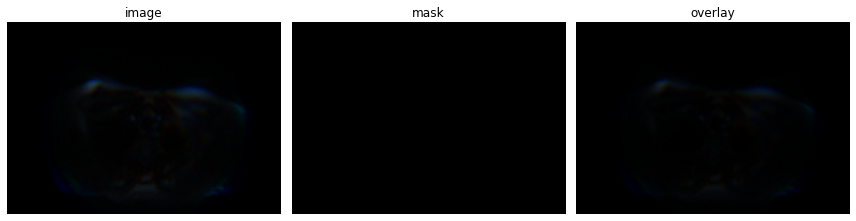

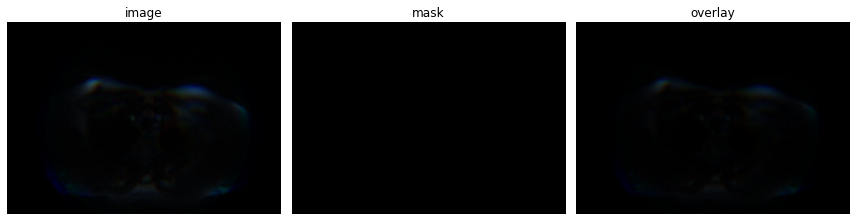

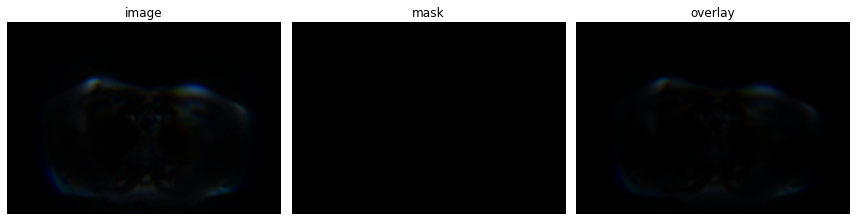

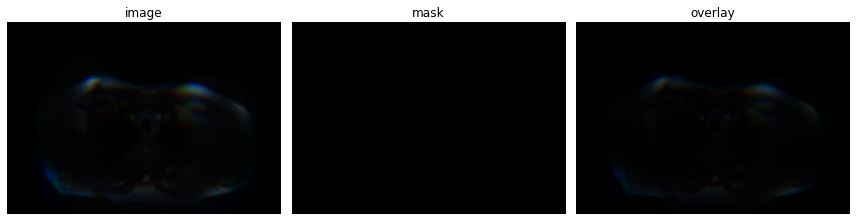

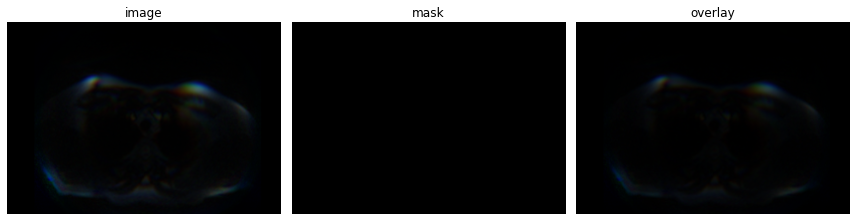

In [35]:
for img, msk in zip(imgs[0][:5], msks[0][:5]):
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 3, 1); plt.imshow(img, cmap='bone');
    plt.axis('OFF'); plt.title('image')
    plt.subplot(1, 3, 2); plt.imshow(msk*255); plt.axis('OFF'); plt.title('mask')
    plt.subplot(1, 3, 3); plt.imshow(img, cmap='bone'); plt.imshow(msk*255, alpha=0.4);
    plt.axis('OFF'); plt.title('overlay')
    plt.tight_layout()
    plt.show()

In [36]:
del imgs, msks
gc.collect()

46624

# 📝 Submission

In [37]:
pred_df = pd.DataFrame({
    "id":pred_ids,
    "class":pred_classes,
    "predicted":pred_strings
})
if not debug:
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
    del sub_df['predicted']
else:
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')[:1000*3]
    del sub_df['segmentation']
    
sub_df = sub_df.merge(pred_df, on=['id','class'])
sub_df.to_csv('submission.csv',index=False)
display(sub_df.head(5))

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,
